In [1]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Featurizer class definition

class Featurizer():
    
    def __init__(self, fp_len, fp_type):
        self.fp_len = fp_len
        self.fp_type = fp_type
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        
        df = df[df['Ki']<=1e4]
        df = df[df['Ki']>0.01]
        labels = df['Ki']
        
        fp = []
        for index, row in df.iterrows():
            fp = row[1:self.fp_len+1]
            fingerprints.append(fp)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels
        
class KlekFeaturizer(Featurizer):
    def __init__(self, fp_len=4860, fp_type='Klek',):
        super().__init__(fp_len, fp_type)
    
class MACCSFeaturizer(Featurizer):
    def __init__(self, fp_len=166, fp_type='MACCS'):
        super().__init__(fp_len, fp_type)
        
class SubFeaturizer(Featurizer):
    def __init__(self, fp_len=307, fp_type='Sub'):
        super().__init__(fp_len, fp_type)

In [3]:
# Text file to DataFrame object

filename = '../ready_datasets/ready_datasets/d2_SubFP_final_file.csv'
df = pd.read_csv(filename)
df = df.dropna()

featurizer = SubFeaturizer()
fp_train, ki_train = featurizer(df)

fp_train = torch.from_numpy(fp_train)
ki_train = torch.from_numpy(ki_train)

assert fp_train.shape[0] == ki_train.shape[0], 'X_train and y_train rows do not match'

In [76]:
fp_train.shape

torch.Size([10325, 307])

In [4]:
# Data loader

from torch.utils.data import DataLoader, TensorDataset

tensor_ds = TensorDataset(fp_train, ki_train)
train = tensor_ds

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [5]:
# Define autoencoder class

fp_len = featurizer.fp_len # Klek=4860, MACCS=166, Sub=307
code_len = 8 # latent space size

class Autoencoder(nn.Module):
    
    torch.set_default_dtype(torch.float64)
    
    def __init__(self, fp_len, code_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(fp_len, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, code_len)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(code_len ,16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, fp_len),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
# Define loss function for VAE

# Define train

def train(train_dataloader, device=device):

    epochs = 40
    
    model = Autoencoder(fp_len, code_len)
    if device == 'cuda':
        model.cuda()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(epochs):
        for (fp, _) in train_dataloader:
            if device == 'cuda':
                fp = fp.cuda()
            encoded, recon = model(fp)
            loss = criterion(recon, fp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
    
    return model
    
# train

model = train(train_dataloader)

# encode

encoded, recon = model(fp_train)
encoded = encoded.detach().numpy()

Epoch: 1, Loss: 0.6885220904319356
Epoch: 2, Loss: 0.6816085872792906
Epoch: 3, Loss: 0.6717870502424773
Epoch: 4, Loss: 0.6577455994792669
Epoch: 5, Loss: 0.6338777271004459
Epoch: 6, Loss: 0.5886302210518528
Epoch: 7, Loss: 0.5060784556921755
Epoch: 8, Loss: 0.3771499775608839
Epoch: 9, Loss: 0.2595599945771155
Epoch: 10, Loss: 0.16873958119404242
Epoch: 11, Loss: 0.11483596507820548
Epoch: 12, Loss: 0.10378285187317002
Epoch: 13, Loss: 0.09836868606197391
Epoch: 14, Loss: 0.0812644904103619
Epoch: 15, Loss: 0.0740009206122656
Epoch: 16, Loss: 0.06665726847766483
Epoch: 17, Loss: 0.06385753167743703
Epoch: 18, Loss: 0.05562776931676863
Epoch: 19, Loss: 0.06312196367735078
Epoch: 20, Loss: 0.05732637078177637
Epoch: 21, Loss: 0.061082236263302
Epoch: 22, Loss: 0.06726984283376795
Epoch: 23, Loss: 0.06556814529857656
Epoch: 24, Loss: 0.06611104392284821
Epoch: 25, Loss: 0.054985834769452735
Epoch: 26, Loss: 0.05783546163558531
Epoch: 27, Loss: 0.06066521166553603
Epoch: 28, Loss: 0.063

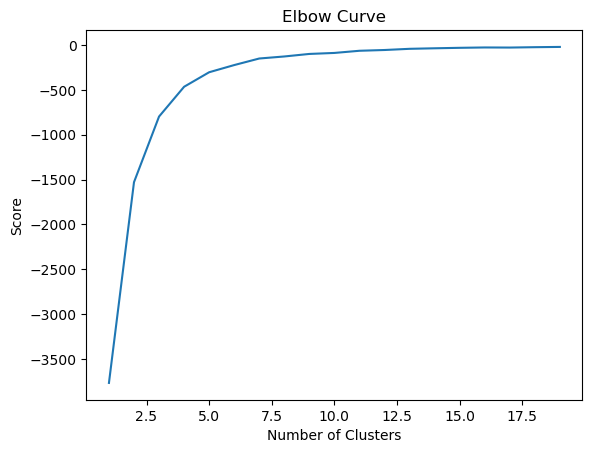

Silhouette score: 0.5828116772188967


In [8]:
from sklearn import cluster
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# Filtering df for active compounds only

activity = (ki_train < 10)
activity = np.array(activity)
encoded_df = pd.DataFrame(encoded)
encoded_df['Activity'] = activity
active_df = encoded_df.loc[encoded_df['Activity'] == True]
active_df = active_df.drop(columns='Activity')

# Choosing optimal number of clusters

Nc = range(1, 20)
kmeans = [cluster.KMeans(n_clusters=i, n_init='auto') for i in Nc]
score = [kmeans[i].fit(active_df).score(active_df) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# Clustering active compounds in 8-dimensional latent space
cluster_num = 8

clu = cluster.KMeans(n_clusters=cluster_num, init='k-means++', n_init='auto', max_iter=1000, 
        tol=0.001, random_state=42, copy_x=True, algorithm='lloyd')
clu.fit(active_df)

pred = clu.predict(active_df)
pred = np.array(pred)

score = metrics.silhouette_score(active_df, pred)
print("Silhouette score:", score)

In [9]:
# Dataset prepatarion for t-SNE visualization 

active_df_tsne = active_df
active_df_tsne['Activity'] = 1
active_df_tsne['Cluster'] = pred+1
tsne_df = pd.DataFrame(encoded)
tsne_df['Activity'] = activity
tsne_df['Cluster'] = 0
tsne_df.update(active_df_tsne)

...tSNE...


<Axes: >

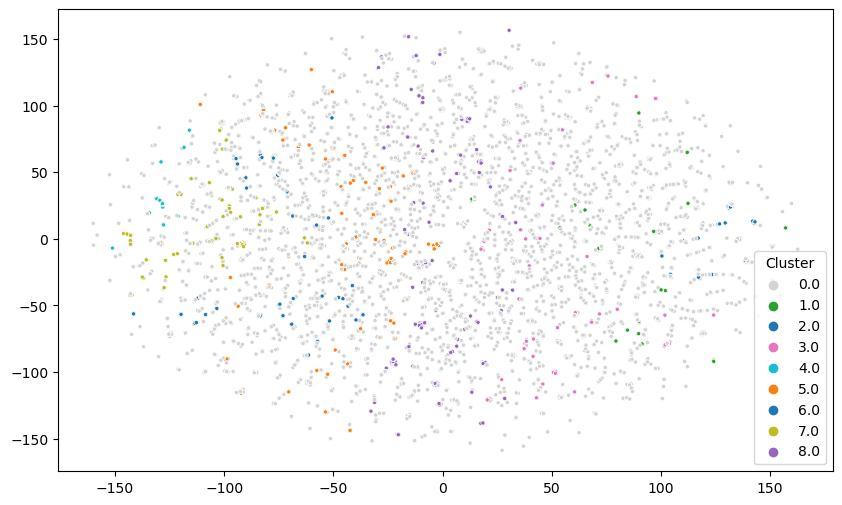

In [10]:
from sklearn.manifold import TSNE
from sklearn import datasets
import seaborn as sns

tsne = TSNE(perplexity=5, learning_rate=200)

print('...tSNE...')
X_tsne = tsne.fit_transform(encoded_df.loc[:, ~encoded_df.columns.isin(['Activity', 'Cluster'])])

colors = ['#D3D3D3', '#2ca02c', '#1f77b4', '#e377c2', '#17becf', '#ff7f0e', '#1f77b4', '#bcbd22', '#9467bd']
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], marker=".", 
                hue=tsne_df['Cluster'], palette=colors,)

In [11]:
# Calculate shilhuette score for each cluster

y = metrics.silhouette_samples(active_df, clu.labels_, metric='euclidean')
scored_points = active_df
scored_points['Score'] = y
scored_points['Cluster'] = clu.labels_ + 1

cluster_scores = pd.DataFrame()

cluster_arr = []
score_arr = []
for cluster in range(1, cluster_num+1):
    scores = scored_points.loc[scored_points['Cluster'] == cluster]
    scores = np.array(scores[['Score']])
    score_arr.append(np.mean(scores))
    cluster_arr.append(cluster)
    
cluster_scores['Cluster'] = cluster_arr
cluster_scores['Score'] = score_arr

# Sort clusters by silhuette score (descending)

cluster_scores = cluster_scores.sort_values('Score', ascending=False)
    
print('Silhouette scores for each cluster:')
print(cluster_scores)

Silhouette scores for each cluster:
   Cluster     Score
4        5  0.918297
1        2  0.905192
7        8  0.902588
2        3  0.864190
6        7  0.848623
5        6  0.835840
0        1  0.820024
3        4  0.815206


In [19]:
cluster_centres = np.array(clu.cluster_centers_)

best_cluster = np.array(cluster_scores['Cluster'])[0]
best_latent = cluster_centres[best_cluster-1]

best_latent = torch.from_numpy(best_latent)
best_decoded = model.decoder(best_latent)
best_decoded.detach().numpy()
np.where(best_decoded.detach().numpy() > 0.5, 1, 0)
fp = np.where(best_decoded.detach().numpy() > 0.5, 1, 0)
idx = np.where(fp == 1)[0]
print(f'Active bits: {idx}')

Active bits: [  1  22  25 273 274 286 294 299 300 301 306]


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc41 = nn.Linear(16, output_size)
        self.fc42 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        mu = self.fc41(h3)
        logvar = self.fc41(h3)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        out = self.fc4(h3)
        return self.sigmoid(out)

class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, latent_size)
        self.decoder = Decoder(latent_size, 128, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [64]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

In [65]:
def train_VAE(train_dataloader, epochs=40, device=device):
    model = VAE(fp_len, code_len)
    criterion = VAELoss()
    if device == 'cuda':
        model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(epochs):
        for (fp, _) in train_dataloader:
            if device == 'cuda':
                fp = fp.cuda()
            encoded, mu, logvar = model(fp)
            loss = criterion(encoded, fp, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    return model

In [66]:
model = train_VAE(train_dataloader, epochs=40, device=device)

Epoch: 1, Loss: 4406.7565
Epoch: 2, Loss: 4315.0272
Epoch: 3, Loss: 4089.9382
Epoch: 4, Loss: 3639.2510
Epoch: 5, Loss: 3070.1135
Epoch: 6, Loss: 2072.3618
Epoch: 7, Loss: 1274.2790
Epoch: 8, Loss: 1035.5454
Epoch: 9, Loss: 793.6941
Epoch: 10, Loss: 690.6518
Epoch: 11, Loss: 677.6644
Epoch: 12, Loss: 651.9665
Epoch: 13, Loss: 610.5319
Epoch: 14, Loss: 539.3085
Epoch: 15, Loss: 523.8468
Epoch: 16, Loss: 444.9105
Epoch: 17, Loss: 464.8127
Epoch: 18, Loss: 420.7977
Epoch: 19, Loss: 430.4863
Epoch: 20, Loss: 432.9452
Epoch: 21, Loss: 406.1917
Epoch: 22, Loss: 447.9496
Epoch: 23, Loss: 385.2543
Epoch: 24, Loss: 454.2532
Epoch: 25, Loss: 475.5185
Epoch: 26, Loss: 373.0539
Epoch: 27, Loss: 428.5199
Epoch: 28, Loss: 424.1102
Epoch: 29, Loss: 392.9182
Epoch: 30, Loss: 450.1161
Epoch: 31, Loss: 411.6364
Epoch: 32, Loss: 387.3285
Epoch: 33, Loss: 439.1787
Epoch: 34, Loss: 385.7232
Epoch: 35, Loss: 354.7432
Epoch: 36, Loss: 400.1433
Epoch: 37, Loss: 376.8432
Epoch: 38, Loss: 337.3964
Epoch: 39, Lo

In [77]:
# encode all data to latent space
encoded = []
for fp in fp_train:
    encoder = model.encoder
    if device == 'cuda':
        fp = fp.cuda()
        mu, logvar = encoder(fp)
        latent = model.reparameterize(mu, logvar)
        encoded.append(latent.detach().cpu().numpy())
    else:
        mu, logvar = encoder(fp)
        latent = model.reparameterize(mu, logvar)
        encoded.append(latent.detach().numpy())


In [80]:
encoded = np.array(encoded)

In [83]:
vae_results = pd.DataFrame(encoded)
vae_results['activity'] = encoded_df['Activity']

In [84]:
# plot latent space
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_results = pca.fit_transform(encoded)
pca_results = pd.DataFrame(pca_results)
pca_results['activity'] = encoded_df['Activity']

Text(0, 0.5, 'PC2')

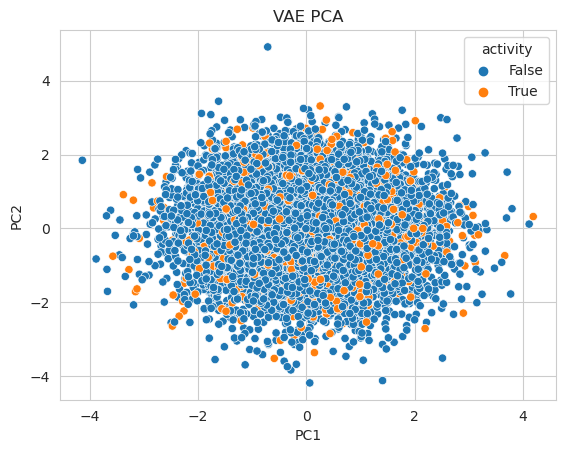

In [94]:
sns.set_style('whitegrid')
sns.scatterplot(x=0, y=1, hue='activity', data=pca_results)
plt.title('VAE PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')